In [263]:
# TODO: Try Data Augmentation on the Malignant Data to increase the sample
# TODO: Look at the AUC ROC Curve

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## 1. Review Dataset and Load Images

### 1.1 Limit GPU Memory Growth

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.2 Collecting Images from Data Folder

In [73]:
dataset = tf.data.Dataset.list_files("data\\*jpg", shuffle = False)

### 1.3 Loading the Images (Resize/Rescale)

In [74]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)

    # Resize the images
    img = tf.image.resize(img/255, [512,512])
    return img

In [75]:
dataset = dataset.map(load_image)

In [76]:
dataset.as_numpy_iterator().next().shape

(512, 512, 3)

### 1.4 Viewing the Raw Images

In [77]:
image_generator = dataset.batch(4).as_numpy_iterator()

In [78]:
plot_images = image_generator.next()

In [79]:
plot_images[0].shape

(512, 512, 3)

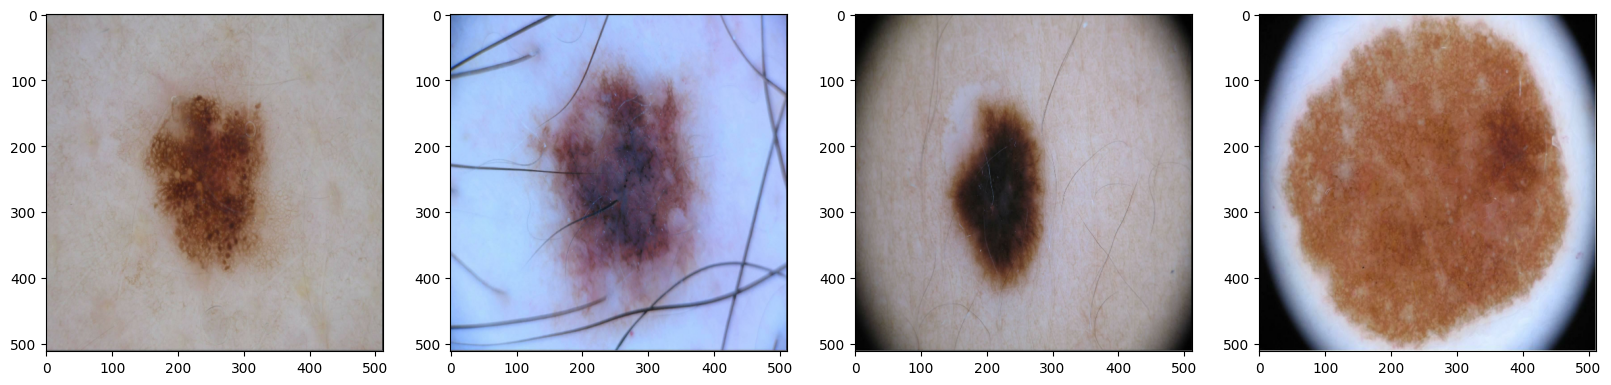

In [80]:
fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

## 2. Partition Data and Into Labels Folders

In [88]:
import pandas as pd
import os

### 2.1 Read from metadata

In [83]:
metadata = pd.read_csv("data\\metadata.csv")

In [86]:
img_label_df = metadata[["isic_id", "benign_malignant"]]

In [87]:
img_label_df

,isic_id,benign_malignant
0,ISIC_0000017,benign
1,ISIC_0000042,benign
2,ISIC_0000048,benign
3,ISIC_0000075,benign
4,ISIC_0000170,malignant
...,...,...
6864,ISIC_9997614,benign
6865,ISIC_9998582,benign
6866,ISIC_9998965,benign
6867,ISIC_9999134,benign


### 2.2 Creating Training, Validation, and Testing DataFrames

In [96]:
from sklearn.model_selection import train_test_split

In [100]:
train_df, test_df = train_test_split(img_label_df, train_size=0.80)
val_df, test_df = train_test_split(test_df, test_size=0.50)

### 2.3 Iterate through DataFrames to Partition Data

In [105]:
# Iterate through the training data
for index, row in train_df.iterrows():
    image = row["isic_id"]+".JPG"
    label = row["benign_malignant"]
    image_path = os.path.join("data", image)
    if os.path.exists(image_path):
        new_filepath = os.path.join("train", label, image)
        os.replace(image_path, new_filepath)

In [106]:
# Iterate through the validation data
for index, row in val_df.iterrows():
    image = row["isic_id"]+".JPG"
    label = row["benign_malignant"]
    image_path = os.path.join("data", image)
    if os.path.exists(image_path):
        new_filepath = os.path.join("val", label, image)
        os.replace(image_path, new_filepath)

In [107]:
# Iterate through the testing data
for index, row in test_df.iterrows():
    image = row["isic_id"]+".JPG"
    label = row["benign_malignant"]
    image_path = os.path.join("data", image)
    if os.path.exists(image_path):
        new_filepath = os.path.join("test", label, image)
        os.replace(image_path, new_filepath)

## 3 Create tf.data.Datasets using the Directory 

### 3.1 Create Datasets from Directory

In [7]:
def process(image, label):
    image = tf.cast(image/255. ,tf.float32)
    return image, label

In [8]:
# Create Train Dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(directory="train",
                                                            labels = "inferred",
                                                            label_mode = "binary",
                                                            class_names = ["benign", "malignant"],
                                                            batch_size = 8,
                                                            image_size = (512,512),
                                                            shuffle = True)
train_dataset = train_dataset.map(process)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

Found 5495 files belonging to 2 classes.


In [9]:
# Create Validation Dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(directory="val",
                                                            labels = "inferred",
                                                            label_mode = "binary",
                                                            class_names = ["benign", "malignant"],
                                                            batch_size = 8,
                                                            image_size = (512,512),
                                                            shuffle = False)
val_dataset = val_dataset.map(process)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Found 687 files belonging to 2 classes.


In [10]:
test_dataset = tf.keras.utils.image_dataset_from_directory(directory="test",
                                                            labels = "inferred",
                                                            label_mode = "binary",
                                                            class_names = ["benign", "malignant"],
                                                            batch_size = 8,
                                                            image_size = (512,512),
                                                            shuffle = False)
test_dataset = test_dataset.map(process)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Found 687 files belonging to 2 classes.


### 3.2 Check Lengths of Partitions

In [7]:
len(train_dataset), len(val_dataset), len(test_dataset)

(687, 86, 86)

## 4. Visualizing the Training Data with Labels

### 

### 4.1 Collecting Train Samples

In [20]:
class_names = {
    "0.0" : "benign",
    "1.0" : "malignant"
}

In [9]:
train_samples = train_dataset.as_numpy_iterator()


In [10]:
res = train_samples.next()

### 4.2 Visualizing Samples

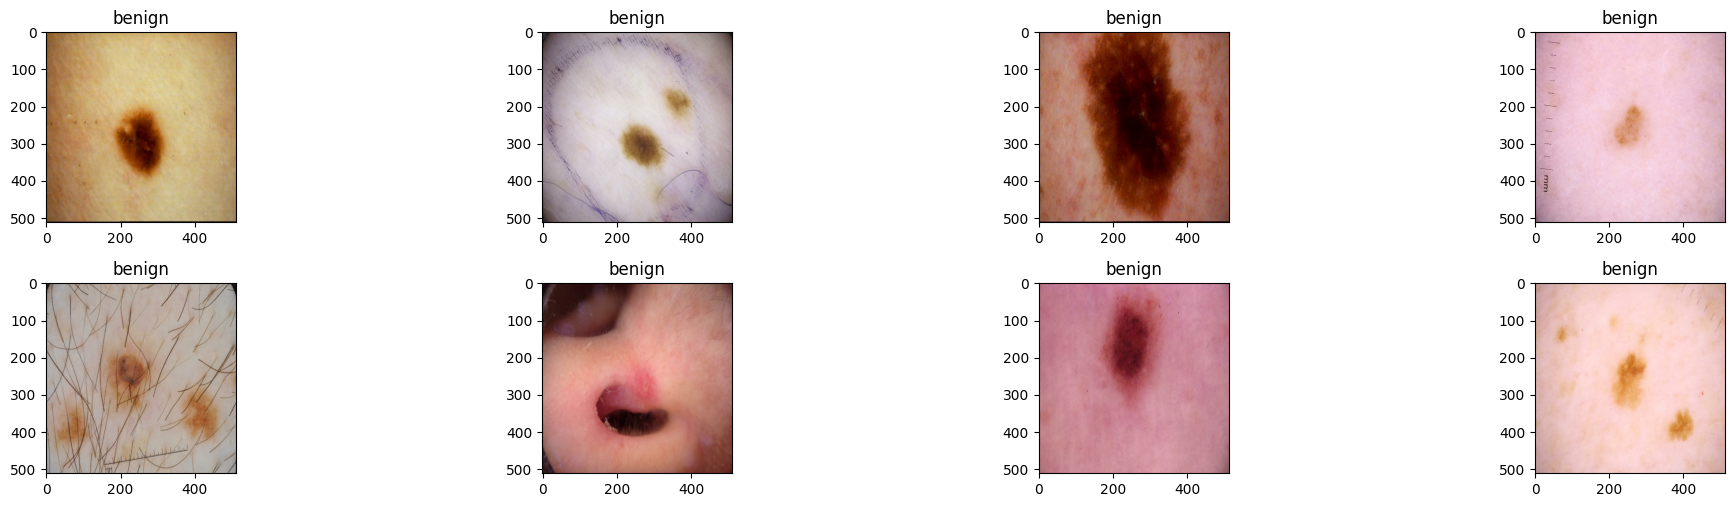

In [11]:
plt.figure(figsize = (20,20))

for i in range(8):
    ax = plt.subplot(8,4, i+1)

    image = res[0][i]
    label = res[1][i]

    label = class_names[str(label[0])]

    plt.imshow(image)
    ax.set_title(label)

plt.tight_layout()
plt.show()

## 5. Build CNN to Classify Melanoma Samples

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input
from tensorflow.keras.models import Model

### 5.1 Functional API Convolutional Neural Network

In [13]:
def build_model():
    # Convolutional Layers
    input_layer = Input(shape = (512,512,3))
    x = Conv2D(32, (3,3), activation = "relu") (input_layer)
    x = MaxPooling2D((2,2)) (x)
    x = Conv2D(64, (3,3), activation = "relu") (x)
    x = MaxPooling2D((2,2)) (x)
    x = Conv2D(128, (3,3), activation = "relu") (x)
    x = MaxPooling2D((2,2)) (x)
    # x = Conv2D(256, (3,3), activation = "relu") (x)
    # x = MaxPooling2D((2,2)) (x)
    # x = Conv2D(512, (3,3), activation = "relu") (x)
    # x = MaxPooling2D((2,2)) (x)

    # Flatten
    x = Flatten() (x)

    # Dense Layers
    x = Dense(128, activation = "relu") (x)
    conv_output = Dense(1, activation = "sigmoid") (x)

    conv_model = Model(input_layer, conv_output)

    return conv_model


In [32]:
conv_model = build_model()

In [33]:
conv_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 255, 255, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 124, 124, 128)     7385

### 5.2 Initializing Optimizers and Loss Functions

In [34]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

In [35]:
loss = tf.keras.losses.BinaryCrossentropy()

### 5.3 Compile the Model

In [36]:
conv_model.compile(optimizer=opt, loss=loss, metrics = ["accuracy"])

### 5.4 Callbacks

In [37]:
# Tensorboard Callback
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [38]:
# Early Stopping Callback
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights=True
)

In [39]:
# Model Checkpoint Callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "melanoma_classification_model.h5",
    monitor = "val_loss",
    save_best_only = True,
    mode = "min",
    save_weights_only = False,
    save_freq = "epoch"
)

### 5.5 Training

In [40]:
hist = conv_model.fit(train_dataset, epochs = 40, validation_data=val_dataset, callbacks=[tensorboard_callback, es_callback, model_checkpoint_callback])

Epoch 1/40


687/687 [==============================] - 70s 100ms/step - loss: 0.2597 - accuracy: 0.9117 - val_loss: 0.2584 - val_accuracy: 0.9127
Epoch 2/40
687/687 [==============================] - 69s 99ms/step - loss: 0.2160 - accuracy: 0.9259 - val_loss: 0.2317 - val_accuracy: 0.9272
Epoch 3/40
687/687 [==============================] - 73s 106ms/step - loss: 0.1954 - accuracy: 0.9301 - val_loss: 0.2291 - val_accuracy: 0.9272
Epoch 4/40
687/687 [==============================] - 71s 103ms/step - loss: 0.1795 - accuracy: 0.9359 - val_loss: 0.2176 - val_accuracy: 0.9272
Epoch 5/40
687/687 [==============================] - 67s 97ms/step - loss: 0.1613 - accuracy: 0.9416 - val_loss: 0.2036 - val_accuracy: 0.9287
Epoch 6/40
687/687 [==============================] - 66s 95ms/step - loss: 0.1486 - accuracy: 0.9465 - val_loss: 0.2524 - val_accuracy: 0.9287
Epoch 7/40
687/687 [==============================] - 66s 95ms/step - loss: 0.1384 - accuracy: 0.9510 - val_loss: 0.2618 - val_accuracy: 0.9185


## 6. Loading the Best Model

In [4]:
melanoma_classification_model = tf.keras.models.load_model("melanoma_classification_model.h5")

In [32]:
melanoma_classification_model.evaluate(test_dataset)

86/86 [==============================] - 6s 69ms/step - loss: 0.1977 - accuracy: 0.9287


[0.19774462282657623, 0.9286754131317139]

## 7. Making Predictions with Best Model

### 7.1 Testing Model to Make Predictions on Single Batch

In [283]:
# Test to see if it makes predictions
test_data = test_dataset.as_numpy_iterator()

In [288]:
test_sample = test_data.next()

In [289]:
y_hat = melanoma_classification_model.predict(test_sample[0])

1/1 [==============================] - 0s 23ms/step


In [290]:
y_hat

array([[0.08201205],
       [0.04941419],
       [0.05225635],
       [0.04224814],
       [0.1597125 ],
       [0.00681787],
       [0.04781982],
       [0.04925239]], dtype=float32)

### 7.2 Visualizing Predictions

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


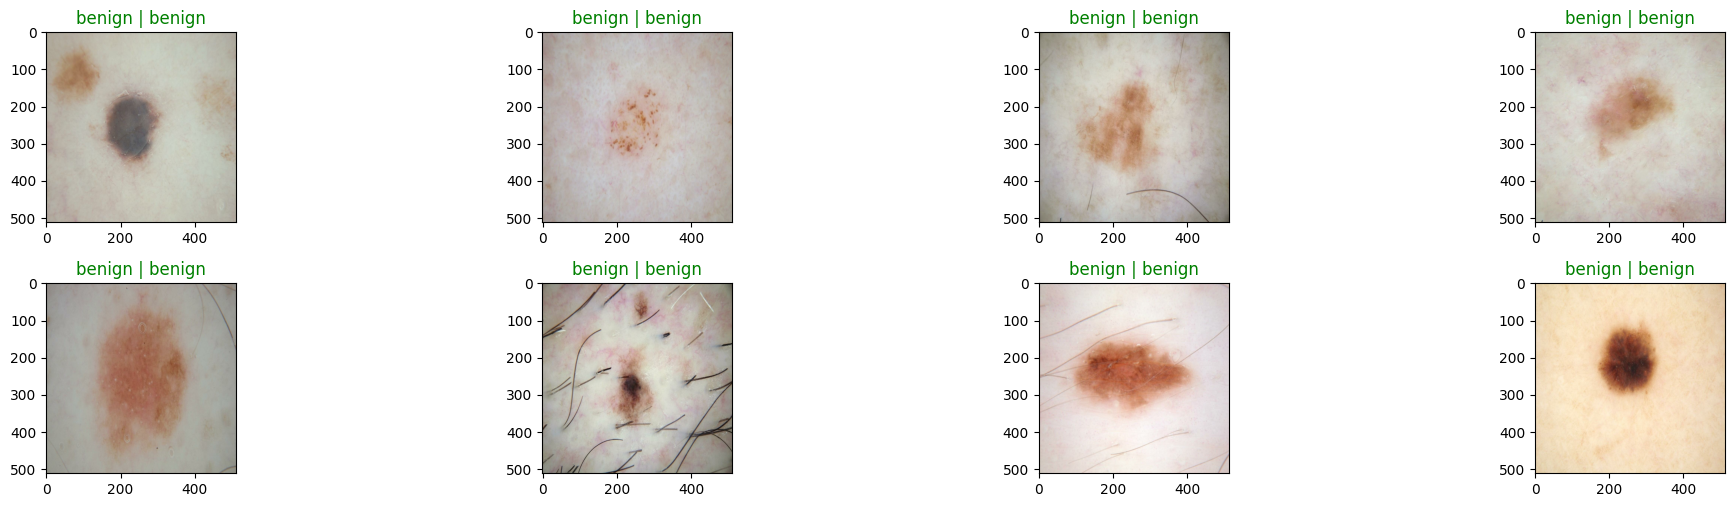

In [291]:
plt.figure(figsize = (20,20))

for i in range(8):
    ax = plt.subplot(8,4, i+1)

    image = test_sample[0][i]
    true_label = test_sample[1][i]

    pred_label = melanoma_classification_model.predict(test_sample[0])[i]
    if pred_label > 0.5:
        pred_label = "malignant"
    else:
        pred_label = "benign"
    true_label = class_names[str(true_label[0])]
    plt.imshow(image)
    if pred_label == true_label:
        ax.set_title(f"{true_label} | {pred_label}", color = "green")
    else:
        ax.set_title(f"{true_label} | {pred_label}", color = "red")

plt.tight_layout()
plt.show()

## 8. Evaluating the Model

### 8.1 Confusion Matrix

In [252]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [206]:
y_pred_probs = melanoma_classification_model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

86/86 [==============================] - 5s 58ms/step


In [256]:
# y_test = test_dataset.map(lambda _, labels: labels)
_, labels = tuple(zip(*test_dataset.unbatch()))
labels = np.array(labels)
y_test = np.squeeze(labels, -1)

In [257]:
y_test.shape, y_pred_labels.shape

((687,), (687,))

In [258]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

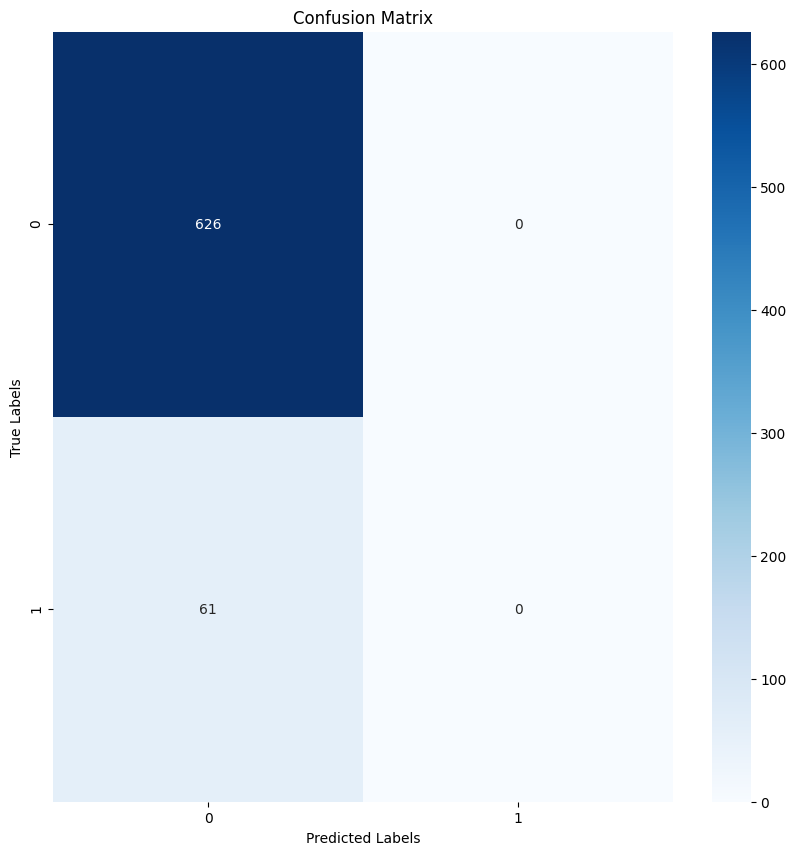

In [261]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()